# RNN for Ford Data

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from keras.models import Sequential 
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer, SimpleRNN
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [105]:
Ford = pd.read_csv("Ford_Cleaned_Date.csv")
Ford.date = pd.to_datetime(Ford.date)
Ford = Ford.set_index("date")
Ford = Ford.iloc[14:, :]
Ford = Ford.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) 

In [106]:
Ford = Ford.dropna()
Ford = Ford[~(Ford.isin([np.inf, -np.inf]).any(axis=1))] 
Ford.shape

(709, 166)

In [107]:
Ford = Ford.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = Ford["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(Ford.columns)}

n = len(Ford)
X_train = Ford[0:int(n*0.9)]
X_val = Ford[int(n*0.7):int(n*0.9)]
X_test = Ford[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [108]:
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = Ford.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = Ford.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = Ford.columns)

In [109]:
def df_to_X_y2(df, target, window_size=10): 
  X = []
  y = []
  for i in range(len(df)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

In [110]:
def kbest_creator(k):
    """
    returns list of k best features and the number of efficient principle compents to use with said k features
    """
    # apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(Ford.columns)
    
    # concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res +1
    res
    
    return feats, res


In [111]:
feats, pcs = kbest_creator(40)
# 9 compenents explain 85% 
pca_kb = PCA(n_components = pcs).fit(X_train[feats].to_numpy())
X_train_kb = pca_kb.transform(X_train[feats].to_numpy())
X_val_kb = pca_kb.transform(X_val[feats].to_numpy())
X_test_kb = pca_kb.transform(X_test[feats].to_numpy())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [112]:
X_val_kb

array([[-1.06563241,  0.69370367,  0.92434346, ..., -0.05362072,
         0.00287444, -0.4964615 ],
       [-0.79540826,  1.27170504, -0.14906832, ...,  0.79086462,
         0.23154422, -0.7777456 ],
       [-0.43234009,  0.4951097 , -1.12007908, ..., -0.56812846,
        -0.84197982,  0.20574449],
       ...,
       [ 0.18287653,  1.03000986, -0.15718927, ..., -0.26700893,
         0.15369108, -0.05617926],
       [ 0.72996495, -0.18960872, -1.0940407 , ..., -0.3444893 ,
         0.79664568,  0.29572466],
       [-0.21823177, -1.26351229,  0.18264846, ...,  0.31310436,
         0.12850171, -0.33408261]])

In [113]:
# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 


In [114]:
print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(628, 10, 12) (628,)
(132, 10, 12) (132,)
(61, 10, 12) (61,)


In [115]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))


In [116]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 8)             672       
                                                                 
 batch_normalization_25 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_28 (LSTM)              (None, 10, 8)             544       
                                                                 
 batch_normalization_26 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_29 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_27 (Bat  (None, 8)              

In [117]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
13/13 [==============================] - 7s 81ms/step - loss: 2.7595 - accuracy: 0.4968 - val_loss: 2.5396 - val_accuracy: 0.5076
Epoch 2/100
13/13 [==============================] - 0s 24ms/step - loss: 2.5384 - accuracy: 0.4904 - val_loss: 2.3914 - val_accuracy: 0.5152
Epoch 3/100
13/13 [==============================] - 0s 25ms/step - loss: 2.3579 - accuracy: 0.5111 - val_loss: 2.2533 - val_accuracy: 0.5227
Epoch 4/100
13/13 [==============================] - 0s 24ms/step - loss: 2.2071 - accuracy: 0.5287 - val_loss: 2.1236 - val_accuracy: 0.5227
Epoch 5/100
13/13 [==============================] - 0s 23ms/step - loss: 2.0704 - accuracy: 0.5669 - val_loss: 2.0039 - val_accuracy: 0.5227
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 1.9429 - accuracy: 0.5541 - val_loss: 1.8942 - val_accuracy: 0.5227
Epoch 7/100
13/13 [==============================] - 0s 24ms/step - loss: 1.8387 - accuracy: 0.5812 - val_loss: 1.7939 - val_accuracy: 0.5227
Epoch 

In [118]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


-----------------------------------------------------------------
train accuracy = 68.949%
test accuracy = 47.541%
test error = 32 out of 61 examples


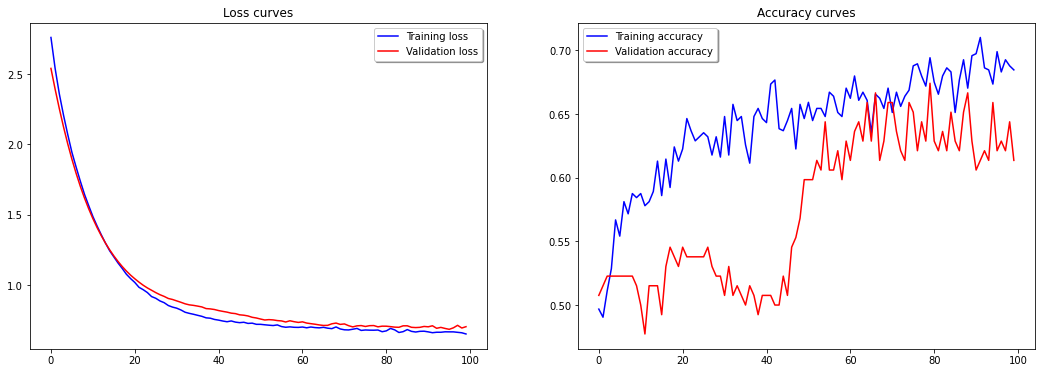

In [119]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [120]:
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 1s 6ms/step
2017-01-02 00:00:00 [0.6834663] 1
2017-01-03 00:00:00 [0.72991323] 0
2017-01-04 00:00:00 [0.7929994] 1
2017-01-05 00:00:00 [0.72071755] 0
2017-01-06 00:00:00 [0.662493] 0
2017-01-09 00:00:00 [0.6167966] 1
2017-01-10 00:00:00 [0.47796986] 1
2017-01-11 00:00:00 [0.41493508] 1
2017-01-12 00:00:00 [0.5169884] 1
2017-01-13 00:00:00 [0.5250819] 0
2017-01-16 00:00:00 [0.42267412] 0
2017-01-17 00:00:00 [0.47867444] 0
2017-01-18 00:00:00 [0.4837931] 0
2017-01-19 00:00:00 [0.8040037] 0
2017-01-20 00:00:00 [0.8599028] 0
2017-01-23 00:00:00 [0.8332225] 0
2017-01-24 00:00:00 [0.7547941] 0
2017-01-25 00:00:00 [0.7011028] 1
2017-01-26 00:00:00 [0.6324359] 1
2017-01-27 00:00:00 [0.69476604] 1
2017-01-30 00:00:00 [0.59312403] 0
2017-01-31 00:00:00 [0.5734816] 0
2017-02-01 00:00:00 [0.67785394] 0
2017-02-02 00:00:00 [0.6294913] 0
2017-02-03 00:00:00 [0.50735617] 0
2017-02-06 00:00:00 [0.53097993] 1
2017-02-07 00:00:00 [0.5710471] 0
2017-02-08 00:00:00 [

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

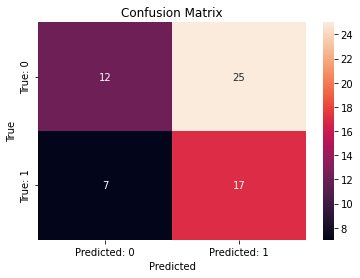

In [121]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])


In [122]:
# model2
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model2
model2 = Sequential()
model2.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model2.add(BatchNormalization())
model2.add(Dense(12, activation='relu'))
model2.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [123]:
model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model2.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 10, 4)             272       
                                                                 
 batch_normalization_28 (Bat  (None, 10, 4)            16        
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 10, 4)             144       
                                                                 
 batch_normalization_29 (Bat  (None, 10, 4)            16        
 chNormalization)                                                
                                                                 
 lstm_32 (LSTM)              (None, 4)                 144       
                                                                 
 batch_normalization_30 (Bat  (None, 4)              

In [124]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(patience=7)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model2.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
13/13 [==============================] - 7s 84ms/step - loss: 1.8126 - accuracy: 0.5016 - val_loss: 1.7542 - val_accuracy: 0.5076
Epoch 2/100
13/13 [==============================] - 0s 23ms/step - loss: 1.7306 - accuracy: 0.4936 - val_loss: 1.6774 - val_accuracy: 0.5227
Epoch 3/100
13/13 [==============================] - 0s 23ms/step - loss: 1.6515 - accuracy: 0.5064 - val_loss: 1.6060 - val_accuracy: 0.5227
Epoch 4/100
13/13 [==============================] - 0s 23ms/step - loss: 1.5774 - accuracy: 0.5255 - val_loss: 1.5396 - val_accuracy: 0.5227
Epoch 5/100
13/13 [==============================] - 0s 23ms/step - loss: 1.5144 - accuracy: 0.5159 - val_loss: 1.4776 - val_accuracy: 0.5227
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 1.4523 - accuracy: 0.5318 - val_loss: 1.4202 - val_accuracy: 0.5227
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 1.3948 - accuracy: 0.5446 - val_loss: 1.3668 - val_accuracy: 0.5227
Epoch 

In [125]:
train_loss, train_acc = model2.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model2.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


-----------------------------------------------------------------
train accuracy = 64.6497%
test accuracy = 42.623%
test error = 35 out of 61 examples


In [126]:
# model3
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model3
model3 = Sequential()

model3.add(LSTM(units=LAYERS[2],input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model3.add(BatchNormalization())
model3.add(Dense(12, activation='relu'))
model3.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [127]:
model3.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model3.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 4)                 272       
                                                                 
 batch_normalization_31 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 12)                60        
                                                                 
 dense_31 (Dense)            (None, 1)                 13        
                                                                 
Total params: 361
Trainable params: 353
Non-trainable params: 8
_________________________________________________________________
None


In [128]:
history = model3.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 4s 25ms/step - loss: 1.2158 - binary_accuracy: 0.4904 - val_loss: 1.1478 - val_binary_accuracy: 0.4924
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 1.1511 - binary_accuracy: 0.5016 - val_loss: 1.0981 - val_binary_accuracy: 0.4848
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0960 - binary_accuracy: 0.5207 - val_loss: 1.0534 - val_binary_accuracy: 0.5303
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0469 - binary_accuracy: 0.5446 - val_loss: 1.0135 - val_binary_accuracy: 0.5682
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0034 - binary_accuracy: 0.5398 - val_loss: 0.9782 - val_binary_accuracy: 0.5455
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9733 - binary_accuracy: 0.5446 - val_loss: 0.9466 - val_binary_accuracy: 0.5303
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - l

In [129]:
train_loss, train_acc = model3.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model3.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 62.4204%
test accuracy = 49.1803%
test error = 31 out of 61 examples


In [130]:
# model4
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model4
model4 = Sequential()

model4.add(LSTM(units=LAYERS[2],input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model4.add(BatchNormalization())
model4.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [131]:
model4.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model4.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 4)                 272       
                                                                 
 batch_normalization_32 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 1)                 5         
                                                                 
Total params: 293
Trainable params: 285
Non-trainable params: 8
_________________________________________________________________
None


In [132]:
history = model4.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 3s 25ms/step - loss: 1.2779 - binary_accuracy: 0.4968 - val_loss: 1.2187 - val_binary_accuracy: 0.4697
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 1.2117 - binary_accuracy: 0.5096 - val_loss: 1.1598 - val_binary_accuracy: 0.4697
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 1.1496 - binary_accuracy: 0.4952 - val_loss: 1.1070 - val_binary_accuracy: 0.4773
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0945 - binary_accuracy: 0.5175 - val_loss: 1.0600 - val_binary_accuracy: 0.4697
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0476 - binary_accuracy: 0.5159 - val_loss: 1.0181 - val_binary_accuracy: 0.4848
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0068 - binary_accuracy: 0.5175 - val_loss: 0.9809 - val_binary_accuracy: 0.4924
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - l

In [133]:
train_loss, train_acc = model4.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model4.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 56.6879%
test accuracy = 54.0984%
test error = 28 out of 61 examples
